In [10]:
import sys
sys.path.insert(0,'/Users/lidorazulay/Documents/DS/Crypto')
from Twitter.connector import connect_remote_sql_alchemy

In [11]:
import matplotlib.pyplot as plt
import sqlite3
from pyproj import Transformer
import json
import pandas as pd
from datetime import datetime

In [12]:
conn = connect_remote_sql_alchemy()

In [13]:
# f"SELECT id, price, processing_date FROM yad2_forsale_history where id in"
#                  f" (select id from yad2_forsale_history where processing_date = '{datetime.today().strftime('%Y%m%d')}' or"
#                  f" processing_date = '{(datetime.today() - pd.to_timedelta('1D')).strftime('%Y%m%d')}')"

# df = pd.read_sql("SELECT id, price, processing_date FROM yad2_history", conn)

df_hist = pd.read_sql("select id, price, processing_date from yad2_forsale_history", conn)
print(df_hist.groupby('processing_date').size())

processing_date
2023-01-21    43872
2023-01-22     8303
2023-01-23     1555
2023-01-24     1164
2023-01-25     1360
2023-01-26     5272
2023-01-27     4498
2023-01-28     4759
2023-01-29     6022
2023-01-30     5820
2023-01-31     5808
dtype: int64


In [14]:
info_cols = ['id', 'row_2', 'row_1', 'line_1', 'square_meters', 'line_2', 'assetclassificationid_text', 'coordinates', 'feed_source', 'address_more', 'search_text', 'date_added']
df_today = pd.read_sql(f"Select {','.join(info_cols)} from yad2_today", conn)
print("Fetched rows:",len(df_today))

Fetched rows: 60310


In [15]:
# df_hist.to_pickle('/Users/lidorazulay/Documents/DS/realestate/resources/yad2_df_hist.pk')
# df_today.to_pickle('/Users/lidorazulay/Documents/DS/realestate/resources/yad2_df_today.pk')

In [16]:
pd.read_sql(f"Select * from yad2_today limit 10", conn)['row_4']

0    [{'key': 'rooms', 'label': 'חדרים', 'value': 6...
1    [{'key': 'rooms', 'label': 'חדרים', 'value': 4...
2    [{'key': 'rooms', 'label': 'חדרים', 'value': 5...
3    [{'key': 'rooms', 'label': 'חדרים', 'value': 3...
4    [{'key': 'rooms', 'label': 'חדרים', 'value': 5...
5    [{'key': 'rooms', 'label': 'חדרים', 'value': 2...
6    [{'key': 'rooms', 'label': 'חדרים', 'value': 5...
7    [{'key': 'rooms', 'label': 'חדרים', 'value': 3...
8    [{'key': 'rooms', 'label': 'חדרים', 'value': 2...
9    [{'key': 'rooms', 'label': 'חדרים', 'value': 5...
Name: row_4, dtype: object

In [17]:
df_today = df_today[~df_today['id'].duplicated()]
print("After rem dup:", len(df_today))

After rem dup: 54237


<AxesSubplot: xlabel='date_added'>

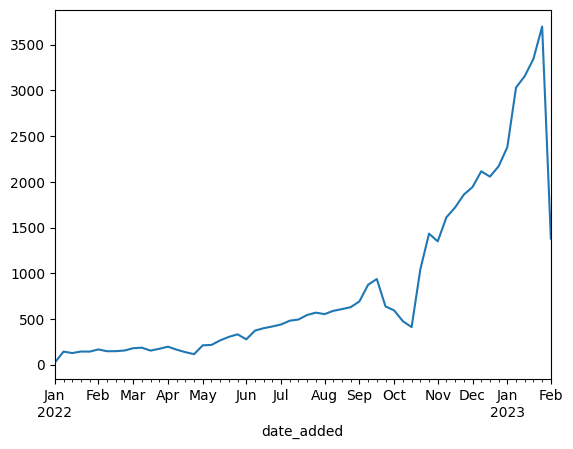

In [18]:
pd.to_datetime(df_today['date_added']).where(lambda x : x > pd.to_datetime('2022-01-01')).to_frame().set_index('date_added').resample('W').size().plot()

In [19]:
info_rename = dict(row_2='city', row_1='street', line_1='rooms', line_2='floor', assetclassificationid_text='status', search_text='info_text')
df_today = df_today.set_index('id').rename(columns=info_rename)
df_today['coordinates'] = df_today['coordinates'].apply(lambda x: json.loads(x.replace("'",'"')))
df_today['info_text'] = df_today['info_text'].apply(lambda x: x.split('תאור לקוח')[1] if len(x.split('תאור לקוח')) > 1 else None )

df_today['floor'] = df_today['floor'].apply(lambda x: 0 if x == 'קומת קרקע' else x.split(' ')[1].replace('-','')).astype(int)
df_today['rooms'] = df_today['rooms'].apply(lambda x: None if x == 'לא צויינו חדרים' else '1' if x == 'חדר אחד' else x.split(' ')[0]).astype(float)
df_today['type'] = df_today['city'].apply(lambda x: x.split(',')[0])
df_today['city_loc'] = df_today['city'].apply(lambda x: ','.join(x.split(',')[1:-1]))
df_today['city'] = df_today['city'].apply(lambda x: x.split(',')[-1])
df_today['lat'] = df_today['coordinates'].apply(lambda x: x.get('latitude'))
df_today['long'] = df_today['coordinates'].apply(lambda x: x.get('longitude'))


In [20]:
df_today

,city,street,rooms,square_meters,floor,status,coordinates,feed_source,address_more,info_text,date_added,type,city_loc,lat,long
id,,,,,,,,,,,,,,,
jav0fytk,מודיעין מכבים רעות,רעות,6.0,160.0,0,במצב שמור,"{'latitude': 31.887879, 'longitude': 35.017617}",commercial,None,"חדש למכירה ! \nברעות א"" בבעלות פרטית , עם ממק...",2022-07-12 23:49:48,דו משפחתי,רעות,31.887879,35.017617
nmoc7pzz,נתניה,דוד רמז,4.0,110.0,5,חדש מקבלן (לא גרו בנכס),"{'latitude': 32.3271762777778, 'longitude': 34...",commercial,None,"במיקום מרכזי בלב העיר, קרוב למוקדי עניין , הי...",2022-10-11 13:10:51,גג/פנטהאוז,מרכז העיר דרום,32.327176,34.854150
kvhurmd4,רחובות,ב' / צפון מערב העיר,5.0,120.0,4,חדש (גרו בנכס),"{'latitude': 31.89894, 'longitude': 34.805596}",commercial,None,מיקום מעולה למי שאוהבים את מרכז העיר מבלי לוו...,2022-06-16 18:54:18,דירה,ב' / צפון מערב העיר,31.898940,34.805596
8qgpipsk,כרמיאל,הגליל,3.0,60.0,4,במצב שמור,"{'latitude': 32.91728265, 'longitude': 35.3039...",commercial,None,ברחוב הגליל דירת 3 חדרים מצוינת להשקעה!\nהדיר...,2022-12-25 12:05:38,דירה,,32.917283,35.303901
p6ht846x,פרדס חנה כרכור,תל ימת כרכור,5.0,141.0,0,משופץ,"{'latitude': 32.480648, 'longitude': 34.985282}",commercial,None,"(6083545) בכרכור, בשכונה המבוקשת חלומות כרכור...",2023-01-31 12:44:33,דירת גן,תל ימת כרכור,32.480648,34.985282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dazedm2w,בני ברק,גבעת רוקח,4.5,90.0,0,חדש (גרו בנכס),"{'latitude': 32.089024, 'longitude': 34.82769}",commercial,מציאה שלא תחזור!!!,דירת ארבע וחצי חדרים במיקום מרכזי ומבוקש.מואר...,2022-12-11 15:06:52,דירה,גבעת רוקח,32.089024,34.827690
yeho2uma,הרצליה,הרצליה פיתוח,6.0,485.0,0,דרוש שיפוץ,"{'latitude': 32.175872, 'longitude': 34.807042}",commercial,None,בהרצליה פיתוח קוטג? למכירה ברח שקט ומבוקש \nע...,2019-08-18 14:14:45,בית פרטי/קוטג',הרצליה פיתוח,32.175872,34.807042
ahs7scxl,רמת גן,אריה בן אליעזר,4.0,100.0,4,חדש (גרו בנכס),"{'latitude': 32.064492, 'longitude': 34.832131...",commercial,None,"במיקום מצוין בקרבת מרום נווה, עורפית ושקטה עם...",2022-06-29 11:52:41,דירה,שיכון מזרחי,32.064492,34.832131


In [21]:
cols_order = ['type', 'city', 'city_loc', 'rooms', 'square_meters', 'floor',
       'status', 'feed_source', 'street',
       'address_more', 'info_text', 'date_added',  'lat', 'long', 'coordinates']

In [22]:
df_today = df_today[cols_order]

In [23]:
df_hist = df_hist.dropna()
df_hist['price'] = df_hist['price'].astype(int)
# pd.options.display.float_format = '{:,.2f}'.format
df_hist = df_hist.drop_duplicates()

In [24]:
print(len(df_hist))
df = df_hist[df_hist['id'].isin(df_today.index)] # filter only to available ids
print(len(df))

62383
53951


In [25]:
df_p = df.pivot(index='id', columns='processing_date', values='price')
df_p = df_p.ffill(axis=1).bfill(axis=1)

In [26]:
df_p

processing_date,2023-01-21,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
id,,,,,,,,,,,
000lge5g,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0,2700000.0
001hfol0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0,1020000.0
0021e7ng,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0,13600000.0
00231too,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0,2430000.0
003iem8d,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0,6999000.0
...,...,...,...,...,...,...,...,...,...,...,...
zzvy85l8,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0,1199000.0
zzvyypie,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
zzwobg1t,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0,1550000.0


In [27]:
# TODO: THIS IS BETTER FOR NOT HAVING FFILL AND BFILL for handling nulls
# df_p.apply(lambda x: (x[x.last_valid_index()] / x[x.first_valid_index()]) -1, axis=1).rename('price_pct')

In [28]:
price_pct = df_p.apply(lambda x: (x[1] / x[0]) -1, axis=1).rename('price_pct')
price_diff = df_p.apply(lambda x: x[0] - x[1], axis=1).rename('price_diff')
first_price = df_p.apply(lambda x: x[0], axis=1).rename('first_price')
last_price = df_p.apply(lambda x: x[1], axis=1).rename('last_price')

In [29]:
df_metrics = pd.concat([first_price, last_price, price_diff, price_pct], axis=1)

In [30]:
df = pd.concat([df_metrics, df_today[~df_today.index.duplicated()]], axis=1)

In [31]:
# df.to_pickle('/Users/lidorazulay/Documents/DS/realestate/resources/yad2_df.pk')

In [32]:
df[df['price_pct'] < 0] # .sort_values()

,first_price,last_price,price_diff,price_pct,type,city,city_loc,rooms,square_meters,floor,status,feed_source,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,
03vkf9xr,2430000.0,2350000.0,80000.0,-0.032922,דופלקס,פתח תקווה,,4.0,120.0,4,משופץ,commercial,גד מכנס 6,None,ברחוב גד מכנס פתח תקווה\nדופלקס גג 4 חדרים\nק...,2022-11-22 13:53:34,32.076390,34.885703,"{'latitude': 32.07639, 'longitude': 34.885703}"
04dnx2oz,4600000.0,4400000.0,200000.0,-0.043478,דירה,הוד השרון,שאר העיר,5.0,150.0,20,חדש (גרו בנכס),commercial,שאר העיר,None,למביני עניין ! חדשה בשוק! חייבת להימכר!\nחולמ...,2023-01-09 14:30:58,32.156317,34.925039,"{'latitude': 32.156317, 'longitude': 34.925039}"
04m094ib,600000.0,585000.0,15000.0,-0.025000,דירה,דימונה,,3.0,60.0,1,משופץ,commercial,דימונה,None,משקיעים שימו לב!!!!!\nבלעדיות חדש מבית אינדיג...,2023-01-12 16:16:25,31.069849,35.036741,"{'latitude': 31.069849, 'longitude': 35.036741}"
04xqy9sq,2740000.0,2620000.0,120000.0,-0.043796,דירה,פתח תקווה,הדר המושבות הותיקה / אם המושבות הותיקה,3.5,95.0,3,במצב שמור,commercial,גדרה 7,None,באם המושבות הוותיקה \nברחוב גדרה המבוקש\nדירת...,2022-12-15 14:57:03,32.105385,34.875115,"{'latitude': 32.105385, 'longitude': 34.875115}"
05vmi0ho,2050000.0,2020000.0,30000.0,-0.014634,דירה,ראשון לציון,אברמוביץ',4.0,100.0,3,משופץ,commercial,קרן היסוד,"מושכרת ב 7200 ש""ח נטו !!",בשכונת אברמוביץ !! תשואה מעולה - דירה בהזדמנו...,2022-12-29 12:31:35,31.971888,34.803901,"{'latitude': 31.9718883225806, 'longitude': 34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znt1qa0l,2100000.0,2080000.0,20000.0,-0.009524,דירה,קרית גת,כרמי גת,4.5,105.0,3,חדש (גרו בנכס),commercial,נחל ירקון,None,למכירה\nדירת 4.5 חדרים בפרוייקט הבוטיק של גבס...,2022-12-18 10:34:39,31.627898,34.771146,"{'latitude': 31.6278979285714, 'longitude': 34..."
zoz8qq1j,4470000.0,4390000.0,80000.0,-0.017897,דירה,תל אביב יפו,הדר יוסף,4.0,96.0,1,משופץ,private,קהילת ורשה 81,None,ללא תיווך.\nמול הפארק (רואים רק ירוק). קרוב ...,2023-01-08 10:11:52,32.108924,34.821862,"{'latitude': 32.108924, 'longitude': 34.821862}"
zuq8qgud,1900000.0,1890000.0,10000.0,-0.005263,דירה,חדרה,הפארק,4.0,110.0,6,במצב שמור,commercial,"חטיבת הנח""ל 16",None,למכירה בבלעדיות חטיבת הנחל 16 חדרה 2 דירות א...,2022-07-18 11:30:00,32.431014,34.934457,"{'latitude': 32.431014, 'longitude': 34.934457}"


In [33]:
# df.query('last_price < 1200000 and price_pct < -0.01 and price_diff < 1e7').sort_values('price_pct')
# df.query('price_pct < -0.01').sort_values('price_pct')
df.sort_values('price_pct')

,first_price,last_price,price_diff,price_pct,type,city,city_loc,rooms,square_meters,floor,status,feed_source,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,
jm1ajoh4,2.900000e+09,2900000.0,2.897100e+09,-0.999000,דירה,רחובות,שעריים,5.0,127.0,7,משופץ,private,מרים מזרחי 20,None,דירה מושלמת 5 חדרים מרווחים. הבית 120 מטר בנו...,2023-01-18 21:30:05,31.890962,34.815849,"{'latitude': 31.890962, 'longitude': 34.815849}"
5p5umwcn,2.850000e+09,2850000.0,2.847150e+09,-0.999000,דירה,גבעת זאב,קרית יערים,3.0,146.0,2,משופץ,private,קרית יערים 32,None,"דירת 3 חדרים מוארת, מרווחת עם נוף מהמם ליער. ...",2023-01-12 11:12:28,31.857616,35.166652,"{'latitude': 31.857616, 'longitude': 35.166652}"
2l8sy200,3.620000e+06,340000.0,3.280000e+06,-0.906077,דירה,רעננה,,5.0,135.0,3,משופץ,commercial,רעננה,במרכז העיר קרוב להכל,דירה יפה מושלמת עורפית \nמשופצת ברמה גבוהה\n...,2022-12-11 10:29:13,32.194014,34.876279,"{'latitude': 32.194014, 'longitude': 34.876279}"
k0gzfp06,1.895000e+07,1895000.0,1.705500e+07,-0.900000,דירת גן,ראש העין,,3.0,95.0,0,משופץ,commercial,ראש העין,גינה מקסימה,בלעדי בראש העין נווה אפק\nדירת גן 2 חדרים כ- ...,2023-01-18 13:13:21,32.092700,34.961719,"{'latitude': 32.0927, 'longitude': 34.961719}"
nkh7auv6,4.400000e+07,4400000.0,3.960000e+07,-0.900000,דירה,ירושלים,"טלביה, קוממיות",4.0,108.0,1,דרוש שיפוץ,commercial,"טלביה, קוממיות","הדירה על קרקע פרטית,","מיקום מעולה שקט ומרכזי חצי קומה לעלות ,\nנכס ...",2022-12-13 19:14:11,31.772357,35.218650,"{'latitude': 31.772357, 'longitude': 35.21865}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4ga8mhk3,NaN,NaN,NaN,NaN,דופלקס,לוד,אחיסמך,6.0,300.0,0,חדש מקבלן (לא גרו בנכס),commercial,רחל אמנו,דופלקס ענק מושקע.,"בשכונת ""גני איילון"" באחיסמך.\nדירת גן 6 חד + ...",2021-12-19 12:36:27,31.940193,34.898324,"{'latitude': 31.9401926764706, 'longitude': 34..."
s7eva2co,NaN,NaN,NaN,NaN,בית פרטי/קוטג',נס ציונה,מרכז מזרחי,4.0,90.0,0,משופץ,commercial,מרכז מזרחי,None,"בית פרטי במפלס אחד !!\nמגרש ענק - כ 580 מ""ר.\...",2022-07-03 09:30:51,31.930159,34.804450,"{'latitude': 31.930159, 'longitude': 34.80445}"
5blfcfkk,NaN,NaN,NaN,NaN,משק חקלאי/נחלה,אשדוד,,NaN,30000.0,0,דרוש שיפוץ,commercial,אשדוד,משק במושב ביצרון,משק במושב ביצרון שקרוב לאשדוד! \nאפשר לבנות 3...,2022-10-25 17:34:58,31.790443,34.645600,"{'latitude': 31.790443, 'longitude': 34.6456}"


In [34]:
# https://www.yad2.co.il/item/rsecw38q

In [35]:
df.loc['rsecw38q']

first_price                                              2990000.0
last_price                                               2990000.0
price_diff                                                     0.0
price_pct                                                      0.0
type                                                          דירה
city                                                         נתניה
city_loc                                            מרכז העיר דרום
rooms                                                          4.0
square_meters                                                130.0
floor                                                            5
status                                                   במצב שמור
feed_source                                             commercial
street                                              מרכז העיר דרום
address_more                                                  None
info_text         בניין בוטיק מטופח המונה 6 דיירים בלבד! דירת 

In [36]:
df.query('last_price < 3000000 and -0.9 < price_pct < -0.01 and price_diff < 1e7').sort_values('price_pct')

,first_price,last_price,price_diff,price_pct,type,city,city_loc,rooms,square_meters,floor,status,feed_source,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,
mhjqj0hg,2110000.0,1890000.0,220000.0,-0.104265,דופלקס,כרמיאל,רמת רבין,6.0,160.0,2,במצב שמור,commercial,רמת רבין,None,למכירה נכס נדיר בשכונת רבין המהממת בלב עיר כר...,2023-01-05 22:51:59,32.904880,35.279011,"{'latitude': 32.90488, 'longitude': 35.279011}"
yu16k5yx,2500000.0,2250000.0,250000.0,-0.100000,דירה,רחובות,רחובות ההולנדית,3.0,80.0,1,משופץ,private,הר הצופים 7,None,ללא תיווך !!!\n\nלמכירה דירת 3 חדרים בשכונת ה...,2023-01-18 12:22:22,31.894735,34.780032,"{'latitude': 31.894735, 'longitude': 34.780032}"
0lqpum7v,1750000.0,1590000.0,160000.0,-0.091429,דירת נופש,חדרה,גבעת אולגה,3.5,70.0,5,משופץ,commercial,גבעת אולגה,None,דירת 3 חדרים מהממת \nחובה להגיע להתרשם! משרדנ...,2022-07-31 13:44:08,32.439991,34.885245,"{'latitude': 32.439991, 'longitude': 34.885245}"
g35omevr,1200000.0,1100000.0,100000.0,-0.083333,דירה,יקנעם עילית,רמת יקנעם,2.5,60.0,5,במצב שמור,commercial,הדס,None,"דירה במיקום הכי טוב ביקנעם, נוף מדהים מרחק הל...",2022-12-29 16:15:35,32.646461,35.091726,"{'latitude': 32.6464614285714, 'longitude': 35..."
q14t4sy8,2450000.0,2250000.0,200000.0,-0.081633,גג/פנטהאוז,אילת,,4.0,200.0,8,משופץ,commercial,אילת,None,למכירה פנטהאוז נדיר ומיוחד במינו במרכז העיר ...,2022-11-23 12:31:00,29.553432,34.944313,"{'latitude': 29.553432, 'longitude': 34.944313}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k1g8nh5o,1820000.0,1799999.0,20001.0,-0.010990,דירה,כרמיאל,הפרסה,6.0,120.0,1,משופץ,private,שיזף 10,None,"דירה 5 חדרים 120 מטר , חדר קטן נוסף מתאים ל...",2023-01-20 08:20:24,32.907151,35.296025,"{'latitude': 32.907151, 'longitude': 35.296025}"
k3z8w5h0,1850000.0,1830000.0,20000.0,-0.010811,דירה,אשקלון,שקמים ואגמים,4.0,112.0,2,חדש (גרו בנכס),private,שדרות עמק יזרעאל 57,None,דירת 4 חדרים כ100 מטר גדולה ומושקעת.\nמיזוג מ...,2022-11-01 10:37:33,31.651801,34.566982,"{'latitude': 31.651801, 'longitude': 34.566982}"
g83k84xc,1890000.0,1870000.0,20000.0,-0.010582,דירה,קרית מלאכי,"כרמי הנדיב, אחוזת רוטנר",4.0,105.0,7,חדש (גרו בנכס),commercial,"כרמי הנדיב, אחוזת רוטנר",None,"בס""ד\nלמכירה בקרית מלאכי בכרמי הנדיב במגדלים...",2023-01-16 09:32:38,31.726171,34.737515,"{'latitude': 31.726171, 'longitude': 34.737515}"


In [37]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1 = np.radians([lat1, lon1])
        lat2, lon2 = np.radians([lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))
def calc_dist(df, deal, distance):
    dist = haversine(df['lat'], df['long'], deal['lat'], deal['long'])
    df['dist'] = dist
    df = df[df['dist'] < distance]
    return df

In [38]:
con_taxes = sqlite3.connect('/Users/lidorazulay/Documents/DS/realestate/resources/nadlan.db')

In [39]:
def get_similar_closed_deals(deal, days_back, dist_km, with_room):
    if np.isnan(deal['lat']) or np.isnan(deal['long']):
        raise ValueError('lat or long are not valid')
    wgs84_itm_to_trans = Transformer.from_crs(4326, 2039)
    cor_x, cor_y = wgs84_itm_to_trans.transform(deal['lat'], deal['long'])
    # print(cor_x, cor_y)
    dt_back = (datetime.today() - pd.to_timedelta(f'{days_back}D')).strftime('%Y%m%d')
    sql_dist_cond = f'and sqrt((pow(corX - {cor_x}, 2) + pow(corY - {cor_y}, 2))/1000000)'
    sql_room_cond = f"and round(misHadarim) = round({deal['rooms']})" if with_room else ""
    q = f'select {sql_dist_cond.split("and")[1]} as dist_from_deal, *  from trans where tariska > {dt_back}' \
        f' {sql_dist_cond} < {dist_km}'\
        f' {sql_room_cond}'\
        f' and helekNimkar = 1.0'
    # print(q)
    df_tax = pd.read_sql(q, con_taxes)
    return df_tax

def plot_deal_vs_sale_sold(other_close_deals, df_tax, deal):
    # When the hist becomes square thats because there a huge anomaly in terms of extreme value
    sale_items = other_close_deals[other_close_deals['rooms'] == deal['rooms']]['last_price']
    sale_items.rename(f'last_price #{len(sale_items)}').hist(bins=min(70, len(sale_items)), legend=True, alpha=0.8)
    sold_items = df_tax['mcirMorach']
    if len(sold_items):
        sold_items.rename(f'realPrice{days_back}D #{len(sold_items)}').hist(bins=min(70, len(sold_items)), legend=True, alpha=0.8)
    plt.axvline(deal['last_price'], color='red', label=f"{deal['last_price']:,.0f}", linewidth=2)
    str_txt = f"{'חדרים'[::-1]} {deal['rooms']},{deal['type'][::-1]}, {deal['street'][::-1]}, {deal['city'][::-1]}, {deal['price_pct']:0.2%}"
    plt.xlim([deal['last_price'] // 2, deal['last_price'] * 3])
    plt.title(str_txt)
    plt.legend()
    plt.show()

In [40]:
deal_id = np.random.choice(df[df['price_pct'] < 0].index)
# deal_id = 'yu16k5yx'
# deal_id = 'zct9jz2a'
# deal_id = 'vgnsg6pf'
deal_id = 'omresoki'
assert deal_id in df.index

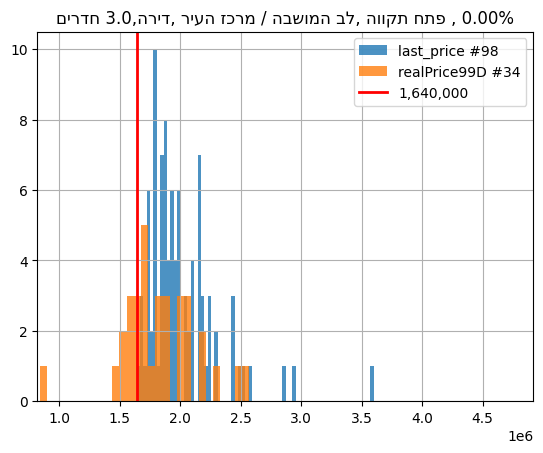

 את הנכס הזה אסור לכם לפספס !!!
משקיעים , זוגות צעירים הנכס הזה בול בשבילכם. שלום רב,שמי רועי חן, בעלים של משרד התיווך רועי חן נדל"ן.משרד התיווך ממוקם בלב שכונת רמת ורבר בפתח תקווה.המשרד מעניק שרות למוכרים ולקונים בפתח תקווה והסביבה
משרדנו מתמחה בעיקר במכירה וקניית נדל"ן למגורים והשקעה בשכונת רמת ורבר.
מקצועיות, אמינות, יושר ושקיפות הם ערך עליון מבחינתנו, מטרתנו אחת להעניק שירות איכותי והעניק ערך מוסף רב ללקוחותינו.
אנו מבינים כי מאחורי כל נכס עומדים אנשים עם סיפור אישי ועל כן אנו פועלים להתאים את תהליך המכירה לצרכי לקוחותינו.
מוכרים / קונים נכס בפתח תקווה והסביבה מוזמנים ליצור איתנו קשר ולקבל ערך מוסף והכוונה.
להערכת שווי נכס ולמקסם את תהליך המכירה של דירתכם צרו קשר עימנו
רועי חן נדל"ן מחברים אנשים לבתים. סוכנות רועי חן נדל"ן 


1

,dist_from_deal,ezor,gush,tarIska,yeshuv,rechov,bayit,knisa,dira,mcirMozhar,...,tifkudBnyn,tifkudYchida,shumaHalakim,mofaGush,tava,mahutZchut,helekNimkar,corX,corY,insertionDate
10,0.329858,29 - מק-מרכז,006380-0117-018-00,20221113,פתח תקווה,ההגנה,16,--,1,544701,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,189401,666152,2022-12-25 14:48:50.104650
12,0.370042,29 - מק-מרכז,006374-0029-007-00,20221115,פתח תקווה,רוטשילד,70,--,1,845000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,188892,666122,2022-12-25 14:48:50.104650
16,0.651553,29 - מק-מרכז,006379-0128-007-00,20221117,פתח תקווה,אהרונסון,3,--,0,1460000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,1,0,בעלות,1.0,189671,665973,2022-12-27 06:09:44.801242
32,0.617465,29 - מק-מרכז,006379-0135-020-00,20221227,פתח תקווה,רמבם,24,--,999,1540000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,189777,666354,2023-01-13 18:04:32.933819
1,0.699518,29 - מק-מרכז,006394-0143-006-00,20221026,פתח תקווה,רוטשילד,104,--,1,1550000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,189059,665685,2022-12-30 23:16:02.109798
31,0.727134,29 - מק-מרכז,006379-0236-003-00,20221222,פתח תקווה,רמבם,37,--,3,1600000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,1,0,בעלות,1.0,189871,666225,2023-01-06 03:25:27.850459
8,0.669739,29 - מק-מרכז,006379-0102-016-00,20221110,פתח תקווה,רמבם,27,--,9,1600000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,2,0,בעלות,1.0,189827,666317,2022-12-25 14:48:50.104650
33,0.468988,29 - מק-מרכז,006378-0032-010-00,20221228,פתח תקווה,נחלת צבי,11,--,6,1600000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,189625,666438,2023-01-13 18:56:57.419201
21,0.802257,29 - מק-מרכז,006383-0104-007-00,20221124,פתח תקווה,אהרונסון,15,--,7,1650000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,189699,665783,2022-12-25 14:48:50.104650
15,0.530523,29 - מק-מרכז,006373-0608-020-00,20221116,פתח תקווה,שדה יצחק,1,--,1,1670000,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות,1.0,188630,666353,2022-12-31 21:22:26.306958


,first_price,last_price,price_diff,price_pct,type,city,city_loc,rooms,square_meters,floor,status,feed_source,street,address_more,info_text,date_added,lat,long,coordinates,dist
id,,,,,,,,,,,,,,,,,,,,
m08vc6kr,10000.0,10000.0,0.0,0.0,דירה,פתח תקווה,עין גנים,3.5,90.0,1,במצב שמור,commercial,פרישמן 29,בבלעדיות!,למכירה בבלעדיות \nברחוב שקט ללא מוצא.\nדירת 3...,2022-08-02 10:59:34,32.092437,34.891456,"{'latitude': 32.092437, 'longitude': 34.891456}",0.785136
omresoki,1640000.0,1640000.0,0.0,0.0,דירה,פתח תקווה,לב המושבה / מרכז העיר,3.0,75.0,1,במצב שמור,commercial,לב המושבה / מרכז העיר,None,"את הנכס הזה אסור לכם לפספס !!!\nמשקיעים , זוג...",2023-01-30 15:43:06,32.090304,34.883511,"{'latitude': 32.090304, 'longitude': 34.883511}",0.000000
a4p3rg41,1650000.0,1650000.0,0.0,0.0,דירה,פתח תקווה,,3.5,85.0,4,במצב שמור,commercial,שרה אהרונסון,None,משקיעים וזוגות צעירים שימו לב!!!!\n\nברוכים ה...,2022-10-25 12:56:58,32.085501,34.888892,"{'latitude': 32.0855007826087, 'longitude': 34...",0.736385
yth5isic,1670000.0,1670000.0,0.0,0.0,דירה,פתח תקווה,,3.0,60.0,3,במצב שמור,commercial,פתח תקווה,None,מנהל מששרד אנדאלק קטלה משרד שלנו מתמחה מכירה ...,2022-08-10 07:45:52,32.084951,34.886825,"{'latitude': 32.084951, 'longitude': 34.886825}",0.672137
17lp9zp7,1690000.0,1690000.0,0.0,0.0,דירה,פתח תקווה,,3.0,60.0,4,משופץ,commercial,פתח תקווה,None,ברחוב אסף שמחוני 17 השקט והמבוקש ! \nדירת 3 ...,2023-01-12 09:42:23,32.084951,34.886825,"{'latitude': 32.084951, 'longitude': 34.886825}",0.672137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
baxxb0m6,2900000.0,2900000.0,0.0,0.0,דירה,פתח תקווה,,3.5,96.0,1,משופץ,commercial,פתח תקווה,None,"בס""ד \nבשכונה מבוקשת,דירה 3.5 חדרים במקום מנצ...",2023-01-15 22:40:57,32.084951,34.886825,"{'latitude': 32.084951, 'longitude': 34.886825}",0.672137
jnaltasv,2950000.0,2950000.0,0.0,0.0,בית פרטי/קוטג',פתח תקווה,רמת ורבר,3.0,105.0,0,משופץ,private,ברל כצנלסון 34,None,"קוטג' טורי פנימי, שופץ מהיסוד ברמת גימור גבוה...",2022-12-31 20:37:57,32.087334,34.875425,"{'latitude': 32.087334, 'longitude': 34.875425}",0.830266
y4n7vri8,3600000.0,3600000.0,0.0,0.0,דו משפחתי,פתח תקווה,קרול,3.0,275.0,0,דרוש שיפוץ,commercial,יהודה לייב פינסקר,מגוון רחב של נכסים ניתן לראות אצלנו בנדלן סנטר,בשכונת קרול בית דו משפחתי במיקום שבין הרכבת ה...,2022-12-29 11:10:27,32.093356,34.883146,"{'latitude': 32.0933556960784, 'longitude': 34...",0.341069


first_price                                              1640000.0
last_price                                               1640000.0
price_diff                                                     0.0
price_pct                                                      0.0
type                                                          דירה
city                                                     פתח תקווה
city_loc                                     לב המושבה / מרכז העיר
rooms                                                          3.0
square_meters                                                 75.0
floor                                                            1
status                                                   במצב שמור
feed_source                                             commercial
street                                       לב המושבה / מרכז העיר
address_more                                                  None
info_text         את הנכס הזה אסור לכם לפספס !!!\nמשקיעים , זו

In [41]:
days_back = 99
dist_km = 1
deal = df.loc[deal_id]
other_close_deals = calc_dist(df, deal, dist_km) # .join(df)
other_close_deals = other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))]
df_tax = get_similar_closed_deals(deal, days_back, dist_km, True)
# display(df_tax)
plot_deal_vs_sale_sold(other_close_deals, df_tax, deal)
from IPython.display import display, HTML
maps_url = f"http://maps.google.com/maps?z=12&t=m&q=loc:{deal['lat']}+{deal['long']}&hl=iw" # ?hl=iw, t=k sattalite
display(HTML(f"""<a href="https://www.yad2.co.il/item/{deal.name}">LINK TO DIRA!!</a> $$$ <a href="{maps_url}">LINK TO DIRA IN MAPS</a>"""))
print(deal['info_text'])
days_online = (datetime.today() - pd.to_datetime(deal['date_added'])).days
display(days_online)
display(df_tax.sort_values('mcirMozhar'))
display(other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))].dropna(subset='price_pct').sort_values('last_price'))
deal

In [42]:
other_close_deals['last_price'].median()

1950000.0

In [43]:
# pip install swifter

In [45]:
# pip install pandas-parallel-apply
#pip install pathos
from pandas_parallel_apply import DataFrameParallel
# dfp = DataFrameParallel(df, pbar=False)
# asdf2 = dfp.apply(f, axis=1)


In [46]:
def get_metrics(deal):
    try:
        other_close_deals = calc_dist(df, deal, dist_km) # .join(df)
        other_close_deals = other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))]
        # print(deal['last_price'], other_close_deals['last_price'].median())
        pct = deal['last_price'] / other_close_deals['last_price'].median() - 1
        length = len(other_close_deals)
    except:
        pct = None
        length = 0
    return (pct, length)

In [47]:
# import swifter
# swifter.set_defaults(force_parallel=True)

In [50]:
dfp = DataFrameParallel(df, n_cores=8, pbar=True)
out = dfp.apply(get_metrics, axis=1)
# df.swifter.apply(get_metrics, axis=1)

In [54]:
df = df.join(pd.DataFrame(out.tolist(), columns=['pct_diff_median','group_size'], index=out.index))

In [ ]:
# pd.DataFrame(out.tolist(), columns=['pct_diff_median','group_size'], index=out.index)

In [55]:
df['rooms'] = df['rooms'].astype(float)

In [ ]:
df.to_pickle('/Users/lidorazulay/Documents/DS/realestate/resources/yad2_df.pk')

In [61]:
df.sort_values('pct_diff_median').query('group_size > 30 '
                                             'and 2 < rooms < 5'
                                             ' and last_price > 500000'
                                             ' and pct_diff_median < -0.1')[:60]

,first_price,last_price,price_diff,price_pct,type,city,city_loc,rooms,square_meters,floor,...,street,address_more,info_text,date_added,lat,long,coordinates,dist,pct_diff_median,group_size
id,,,,,,,,,,,,,,,,,,,,,
h0dodaug,575000.0,575000.0,0.0,0.0000,בית פרטי/קוטג',חדרה,נחליאל,4.0,143.0,1,...,חטיבת כרמלי,None,"נכס מספר: 10372, זכות לדירה בחדרה נוף הנחל קר...",2023-01-05 11:49:17,32.445907,34.927739,"{'latitude': 32.4459070294118, 'longitude': 34...",39.759315,-0.711779,33
kaowwtqu,2400000.0,2250000.0,150000.0,-0.0625,דירה,תל אביב יפו,,4.0,90.0,1,...,טשרניחובסקי,בלב ת''א,"למכירה נכס מסחרי בקומת מרתף, \nבמיקום הכי מבו...",2022-05-15 13:28:28,32.073304,34.772138,"{'latitude': 32.0733041132075, 'longitude': 34...",10.661818,-0.701987,329
aoru05n3,1500000.0,1500000.0,0.0,0.0000,דירה,ירושלים,רחביה,4.0,98.0,1,...,דרך עזה 36,None,למכירה ברחביה במיקום נדיר דירת 4 חדרים בדמי מ...,2023-01-04 14:50:12,31.772418,35.213770,"{'latitude': 31.772418, 'longitude': 35.21377}",47.124966,-0.645807,110
y1ei3xtb,1450000.0,1450000.0,0.0,0.0000,דירה,ירושלים,רחביה,4.0,100.0,0,...,רחביה,None,"בדמי מפתח במרכז רחביה, דירה 4 חדרים + מרפסת,...",2023-01-09 16:30:36,31.774515,35.213359,"{'latitude': 31.774515, 'longitude': 35.213359}",46.924348,-0.637500,82
mgyjb3nc,1350000.0,1350000.0,0.0,0.0000,דירה,תל אביב יפו,הצפון הישן - דרום,2.5,40.0,0,...,בן יהודה,None,פריים לוקיישן !!! ברחוב בן יהודה ליד פינת מאפ...,2021-11-23 11:41:45,32.084964,34.771961,"{'latitude': 32.0849638592058, 'longitude': 34...",10.525734,-0.621318,142
bgh5vmxw,1100000.0,1100000.0,0.0,0.0000,דירת גן,ירושלים,,3.0,60.0,1,...,ירושלים,"דירה בדמי מפתח - חצר כ- 50 מ""ר - בקומת קרקע",חדשה בשוק - בקרית משה דירת גן בדמי מפתח \n3 ח...,2021-05-31 11:50:15,31.786008,35.175258,"{'latitude': 31.786008, 'longitude': 35.175258}",43.620830,-0.600726,63
8p82lweb,1400000.0,1400000.0,0.0,0.0000,דירה,ירושלים,קטמון הישנה,3.0,73.0,1,...,חזקיהו המלך 13,None,למכירה בדמי מפתח!! דירת 3 חדרים מקסימה במיקום...,2022-08-02 16:46:29,31.762613,35.212908,"{'latitude': 31.762613, 'longitude': 35.212908}",47.896408,-0.569231,75
8yiq5u30,1350000.0,1350000.0,0.0,0.0000,דירה,בני ברק,,4.0,80.0,5,...,הרב כהנמן,בטאבו משותף ללא משכנתא!,בטאבו משותף ללא משכנתא!!!\nבמרכז העיר דירת 80...,2023-01-22 12:22:40,32.079075,34.841524,"{'latitude': 32.079074511811, 'longitude': 34....",4.148099,-0.550000,41
lq7doxvj,1050000.0,1050000.0,0.0,0.0000,דירה,חיפה,רמת בן גוריון,4.0,80.0,2,...,אורן 35,None,None,2021-01-19 00:10:39,32.784100,34.997013,"{'latitude': 32.7841, 'longitude': 34.997013}",77.878454,-0.533333,82


In [ ]:
other_close_deals['rooms'].astype(float).astype(int)

In [ ]:
# other_close_deals

In [ ]:
# df_tax.sort_values('mcirMorach', ascending=False)

In [ ]:
display(HTML(f"""<a href="https://www.yad2.co.il/item/{'298sxaie'}">NICE APERTMENT LINK TO DIRA!!</a>"""))

In [ ]:
# https://www.yad2.co.il/item/298sxaie
# https://www.yad2.co.il/item/ceec8bob

In [ ]:
# https://www.yad2.co.il/item/omresoki?utm_source=dooron&utm_medium=internal&utm_campaign=dooron-ad-view&openedFrom=Dooron

In [ ]:
pd.read_sql("SHOW CREATE TABLE yad2_history", conn)

In [ ]:
import pandas as pd
df_all_history = pd.read_sql("SELECT * FROM yad2_history", conn)

In [ ]:
pd.DataFrame([datetime.today().date()]).dtypes

In [ ]:
df_all_history_t = df_all_history.copy()

In [ ]:
df_all_history_t['processing_date'] = pd.to_datetime(df_all_history_t['processing_date'])

In [ ]:
# df_all_history_t['id'].nunique()
df_all_history_t['id'].nunique()

In [ ]:
df_all_history_t.sort_values(['id', 'processing_date']).groupby(['id','price']).first() # .reset_index()['id'].value_counts()

In [ ]:
df_all_history.loc['5lfffhj6']

In [ ]:
df_all_history_t_a = df_all_history_t.sort_values(['id', 'processing_date']).groupby(['id','price']).first().reset_index()

In [ ]:
df_all_history_t_a['id'].value_counts()

In [ ]:
df_all_history_t_a

In [ ]:
conn.cursor().execute(
        "CREATE TABLE IF NOT EXISTS yad2_history(id VARCHAR(255) not null, price float, processing_date DATE not null)")

In [ ]:
df_all_history_t_a.to_sql("yad2_history", conn, if_exists="append", index=False)

In [ ]:
pd.read_sql("truncate table yad2_forsale_history", conn)

In [ ]:
conn = connect_sql_alchemy()

In [ ]:
import sqlalchemy
dtype = {
    "price": sqlalchemy.Integer,
    "processing_date": sqlalchemy.Date
}
df_all_history_t_a.to_sql("yad2_forsale_history", conn, if_exists="append", index=False, dtype=dtype)

In [ ]:
pd.read_sql("select count(*) from yad2_forsale_history", conn)

In [ ]:
df_all_history_t_a